# Stick slip cycles

## Velocity-dependent, static-kinematic type friction

You have explored Amonton's friction law which says that the shear stress needed to start moving two frictional surface against each other, $\tau_s$, is given by $\tau_ = \mu_s \sigma_n$ where $\mu_s$ is the _static_ friction coefficient, and $\sigma_n$ the normal stress. 
As your experiments with the inclined plane showed, $\mu$ is called the _internal angle of friction_ as it relates to the critical slope where a block would start moving as $\mu = \tan(\phi)$, i.e. the plane has to be at an angle of $\arctan(\mu)$ for sliding.


Friction can be quite complicated, but the first step to move beyond Amonton is to allow for a sliding friction when the surface is moving, the _dynamic_ friction $\mu_d$, such that $\tau_s = \mu_s \sigma_n$, with $\mu_s < \mu_d$, typically.

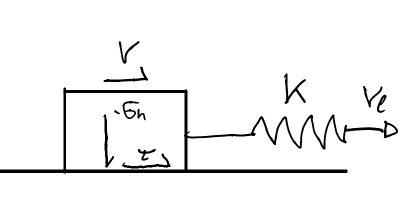

Let's assume that there is a constant loading velocity, $v_0$, extending a spring coupled to a frictional slider, just like in the stick-slip demonstration where we explored a number of different rough sliding surfaces and loading speeds.

If $x$ is the location of the slider, and $x_l$ the location of the load, and if $x_l=0$ at $t=0$, then $x_l = t v_l$. Hooke's law says that the pull force stored in the spring is 

$F_s= k \delta x = k (x_l-x) = k (v_lt-x)=-k(x-v_lt).$ 

This is a load on the mass of the slider such that we get an equation like 

$F_i + F_f(\dot{x}) + F_s =0$ 

where $F_i$ is inertia, $F_i = m \ddot{x}$, as for the harmonic oscillator, and $F_f(\dot{x})$ a velocity-dependent friction, which is like the damping term of the harmonic oscillator from before. If $\mu(\dot{x})$, then $F_f =  -\mathrm{sgn}(\dot{x}) \sigma_n  \mu$, with normal force $\sigma_n$, where $\mathrm{sgn}$ is the sign function, which is 1 or -1, depending on its argument being $>0$ or $<0$, to account for the direction of the pull, and friction resisting it. The full force balance for sliding motion is 

$m\ddot{x} - \mathrm{sgn}(\dot{x}) \sigma_n  \mu_s - k(x-v_lt)=0$.

Let us first define a velocity dependent friction function.

In [13]:
import numpy    as     np
def friction(vel,mu_s,mu_d,vmax): # linear drop version
    vela = np.abs(vel);
    if(vmax>0): # case where there is a non-zero vmax
        fric = np.ones(np.size(vel))* mu_d;
        ind1 = np.where(vela <= vmax)
        fric[ind1] = mu_d + (mu_s-mu_d)*(1-vela[ind1]/vmax)
    else: # instant drop
        fric = np.ones(np.size(vel))* mu_s;
        ind = np.where(vela>0)
        fric[ind] = mu_d
    return fric if len(fric) > 1 else fric[0]  # Return scalar if input was scalar

Everytime we have a new function, let's make sure it works, by plotting it. This is what I mean by "check it out".

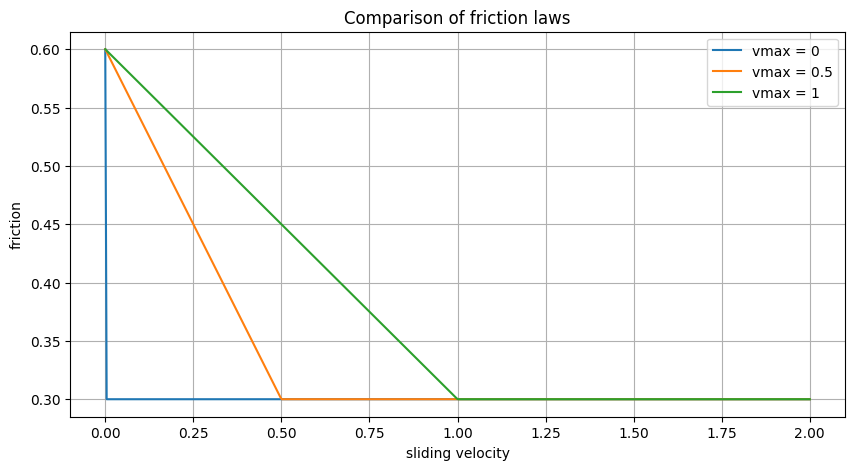

In [14]:
import matplotlib.pyplot as plt
vel = np.linspace(0,2,500)
plt.figure(figsize=(10, 5))
plt.plot(vel,friction(vel,0.6,0.3,0),label='vmax = 0')
plt.plot(vel,friction(vel,0.6,0.3,.5),label='vmax = 0.5')
plt.plot(vel,friction(vel,0.6,0.3,1),label='vmax = 1')
plt.ylabel('friction');plt.xlabel('sliding velocity')
plt.legend();plt.grid()
plt.title('Comparison of friction laws')
plt.show()

Does it look OK? Later, see what happens if you change $\mu_d$, $\mu_s$, and $v_{max}$, for example. 

Now, for the ODEs to solve the slider problem where this friction applies, let's be inspired by the harmonic oscillator from last time. 

\begin{align}
F_g + F_f + F_s = 0
\end{align}
or, as we dervied above,
\begin{align}
m \ddot{x} -   \mathrm{sgn}(\dot{x}) \sigma_n \mu(\dot{x}) - k(x-t v_l) = 0
\end{align}

such that inertia is balanced by the frictional force, and driven by the continuously extending spring, driven by $v_l$. 
Again, introduce $\dot{x} = y$ to only have first order derivatives with time. Then, we need to solve for the time evolution of $\{x,\dot{x}\}=\{x,y\}$. 

If the shear force $F_s$ is smaller than the static normal force, $F_n=\sigma_n \mu_s$, then there is no motion. This means for $-k|x-x_l| < \mu_s\sigma_n$, things remain at rest, and $\dot{x}=0$. Else,
\begin{align}
\dot{x} = y\\
m \dot{y} - \mathrm{sgn}(\dot{x})  \sigma_n  \mu(y)  -k(x-tv_l)=0\\
\dot{y} = \frac{k(x-tv_0)+ \mathrm{sgn}(\dot{x})  \sigma_n  \mu(y)}{m}\\
\end{align}

These are the two equations we will solve, for the displacement and the velocity, respectively. 
We can write as computer code for the ODE solver from before, using our friction function, and first defining a class of parameters which default values.

In [15]:
from   scipy import integrate # scipy solvers
from dataclasses import dataclass,astuple,asdict # for C-like structure

@dataclass
class parameters:                 # define parameters for functions, default values
    m    :float = 1 # mass
    k    :float = 10 # spring stiffness
    mu_s :float = 0.3 # static friction
    mu_d :float = 0.2 # dynamic friction
    sn   :float = 10 # normal force
    vl   :float = 0.1 # load point velocity
    vmax :float = 0 # scale of frictional reduction
    ndim :int = 2 # dimensions of ODE
    veps :float = 1e-3 # velocity cutoff

def xl(t,vl): # computes the load point position given velocity vl.
    return t*vl

def stick_slip_ode(xvec,t,m,k,mu_s,mu_d,sn,vl,vmax,ndim,veps):# derivatives in the format scipy ODE int wants, as above
    x, v = xvec
    F_spring = -k*(x - xl(t,vl))
    if(np.abs(v) < veps and np.abs(F_spring) < mu_s*sn):
        return [ 0, 0]
    else:
        return [ v, (F_spring  - np.sign(v)*sn*friction([v],mu_s,mu_d,vmax))/m]
def ode_solver(ode_function,xinit, time, par): # simple call to scipy solver
    xout     = integrate.odeint(ode_function, xinit, time, astuple(par), rtol=1e-14,atol=1e-5)
    return xout

Let's see what this system does. Try a few combinations of $v_0$ and $k$, and $m$. Does this look like what you got in the experiments? 

Explore by changing the frictional parameters, the pull, the stiffness, the mass, whatever you can think of. Plot the displacement against time, the pulling force against time, displacement against velocity.

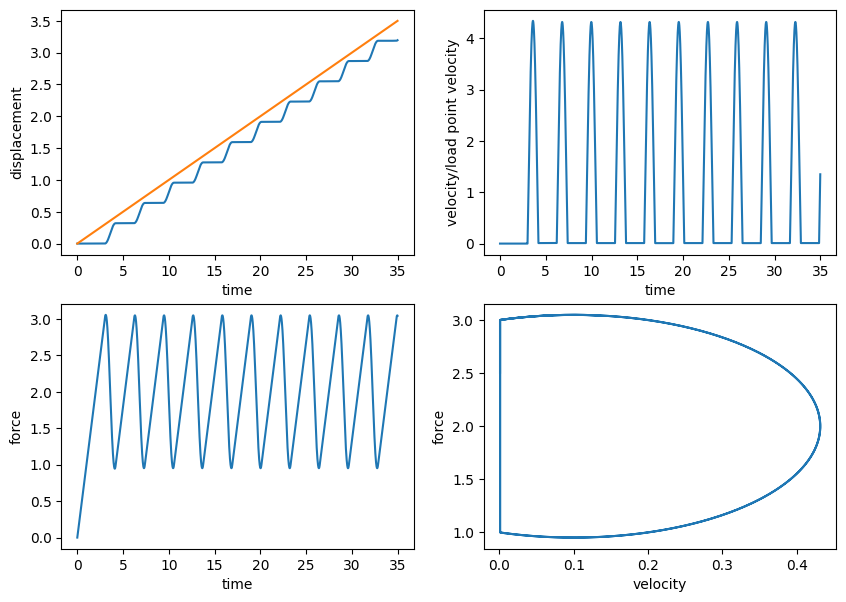

In [16]:
nsteps=10000
t = np.linspace(0,35,nsteps)
par        = parameters();
xsol = ode_solver(stick_slip_ode,[0,0],t,par); # solve the stick slip ODEs
x=xsol[:,0];v=xsol[:,1];F=-par.k*(x-xl(t,par.vl));
# plotting
plt.figure(figsize=(10, 7))
plt.subplot(2, 2, 1) 
plt.plot(t,x,t,xl(t,par.vl));plt.xlabel('time');plt.ylabel('displacement')
plt.subplot(2, 2, 2) 
plt.plot(t,v/par.vl);plt.xlabel('time');plt.ylabel('velocity/load point velocity')
plt.subplot(2, 2, 3) 
plt.plot(t,F);plt.xlabel('time');plt.ylabel('force')
plt.subplot(2, 2, 4) 
ind=range(nsteps-2000,nsteps);plt.plot(v[ind],F[ind]);plt.ylabel('force');plt.xlabel('velocity')
plt.show()

Additional experiments to conduct: 
- Modify `mu_s_values` and `mu_d_values` to explore different static and dynamic friction coefficients.
- Modify `sigma_n_values` to test different normal stress levels.
- Observe how displacement changes with different parameters.


How does increasing normal stress affect the slip behavior? What can we infer about stick-slip behavior from this plot? Why do the curves have distinct but similar patterns?

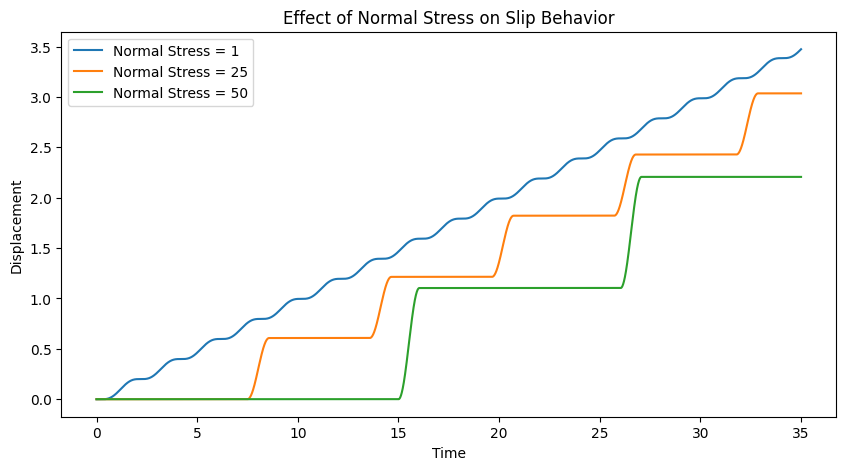

In [17]:
# Testing different normal stresses
sigma_n_values = [1,25, 50]
plt.figure(figsize=(10, 5))
for sigma_n in sigma_n_values:
    par = parameters(sn=sigma_n)  # Corrected parameter name
    sol = ode_solver(stick_slip_ode,[0, 0], t, par)  # Fixed missing arguments
    plt.plot(t, sol[:, 0], label=f'Normal Stress = {sigma_n}')
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title('Effect of Normal Stress on Slip Behavior')
plt.legend()
plt.show()

How does varying the static and dynamic friction coefficients affect slip behavior? What real-world geological processes might these plots help us understand? What additional variables could we explore to expand this analysis?

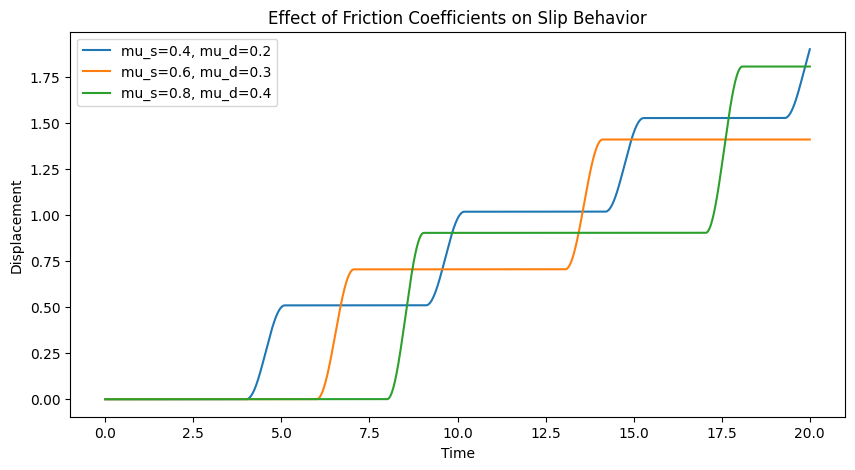

In [18]:
# Define friction coefficient values
#Note: here we make new mu_s and mu_d values other than the default ones seen in the parameters.This helps us compare values easily in one plot
mu_s_values = [0.4, 0.6, 0.8]  # Static friction values
mu_d_values = [0.2, 0.3, 0.4]  # Dynamic friction values

# Define time array
t = np.linspace(0, 20, 10000)

# Plot results for different friction coefficients
plt.figure(figsize=(10, 5))
for mu_s, mu_d in zip(mu_s_values, mu_d_values):
    par = parameters(mu_s=mu_s, mu_d=mu_d)
    sol = ode_solver(stick_slip_ode,[0, 0], t, par)
    plt.plot(t, sol[:, 0], label=f'mu_s={mu_s}, mu_d={mu_d}')

plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title('Effect of Friction Coefficients on Slip Behavior')
plt.legend()
plt.show()


## Quasi-static rate state friction without inertia but possibly more than one state variable. 
Now, let us consider a more complicated dependence of friction, what is called __rate-state friction__ (RSF) behavior. In general, experiments find a sliding velocity and time dependence, like so 

$\mu = \mu_0 + a \ln\left(\frac{v}{v_0}\right) + b \ln\left(\frac{\theta}{D_c/v_0}\right)$, 

where $a$ and $b$ are parameters, $D_c$ and $v_0$ reference length and velocity scales, respectively, and $\theta$ a _state variable_ which allows for effects other than velocity dependent friction, in particular _healing_, that is an increase of static friction with _hold time_.  We then need to pair the friction equation with an _evolution law_ that captures the state variable evolution, such as 

$\dot{\theta} = 1-\frac{v\theta}{D_c},$

which is called the _ageing law_. This means that in steady-state, when $\dot{\theta}=0$, $\theta_{ss} = \frac{D_c}{v}$. Also, for this law, if there is no sliding, $v=0$, then $\dot{\theta} = 1$, a linear increase of the state variable with time. The state variable here plays the role of a typical lifetime of contacts.

Let us consider this behavior and neglect inertia.

The rate- and state friction is described by the following governing equations are in general something like

\begin{align}
\tau = F[V, \theta_1, \theta_2, ... ] \\
\dot \theta_1 = G_1[V, \theta_1, \theta_2, ...] \\ 
\dot \theta_2 = G_2[V, \theta_1, \theta_2, ...] \\ 
...
\end{align}
where we might allow for more than one state variable, $\theta_1$, $\theta_2$, $\ldots$, with 

$\mu = \mu_0 + a \ln\left(\frac{v}{v_0}\right) + b_1 \ln\left(\frac{\theta_1}{\theta_0}\right) + b_2 \ln\left(\frac{\theta_2}{\theta_0}\right)$, 

with $\theta_0 = \frac{D_c}{v_0}$, and we will now use a different, the Ruina, _slip law_ version of the state variable evolution laws

$
\dot{\theta}_i = -\frac{v}{D_c} \left(\theta_i + b_i \log\frac{v}{v_0}\right).
$


The simpliest form of interaction between the rate and state friction and elastic deformation is described by the one degree spring-slider system governed by the rate and state friction where we now do only consider quasi-dynamic sliding, not using the mass/inertia. 

Following Gu et al. (1984), we can rewrite the equations and solve for  a logarithmic sliding velocity

$
x = \ln\left(\frac{v}{v_0}\right),
$

and a normalized friction difference from the reference, or shear stress, since $\tau = \mu \sigma_n$ and we hold $\sigma_n$ constant,


$
y = \frac{\tau - \tau_0}{a},
$

with $\Theta=\frac{\theta}{a}$ a non-dimensional state variable 

$
\Theta_i =\beta_i \log\left(\frac{\theta_i}{\theta_0}\right),
$

where $\beta = \frac{b}{a}$.

With a non-dimensional stiffness, $\kappa = \frac{k D_c}{a\sigma_n}$, the governing equations for the evolution of ${\bf x}=\{x,y,v'_l\}$ can be written as 

\begin{align}
\frac{d x}{dT} &= e^x (-\kappa + y + \lambda x) + \kappa v'_l  \\
\frac{d y}{dT} &= \kappa (v'_l - e^x) \\
\frac{d v_l}{dT} &= v'_l\\
\end{align}

where $T=\frac{t}{\theta_0}$ is a non-dimensionalized time, $v_l'=v_l/v_0$, $\lambda = \beta-1$, and a critical stiffness can be derived as

$
\kappa_c = \lambda = \beta-1 = \frac{b-a}{a},
$

The system could be further condensed into a 2-D description, but we carry three variables explcitly for simplicity where $z=x$ is the displacement.


In [19]:
# Solve an elastic spring-slider system governed by the rate and state friction.
# A numerical implementation of Gu et al. (1984).
@dataclass
class rs2_parameters:
    kappa:float = 1 # non-dim stiffness, normalized to kappa_c, i.e. in multiples of lambda 
    mu_0 :float = 0.6
    a    :float = 0.01
    b    :float = 0.015
    Dc   :float = 1
    mode :int   = 1
    ndim  :int   = 3
        
def rsf_ode(x, t, kappa,mu_0,a,b,Dc,mode,ndim): # x,y,z = x,y,v'_l; x = log(v/v_0); y = (tau-tau_0)/a; z = displacement
    llambda  = b/a -1
    k   = kappa * llambda 
    vl      = vload(t, mode)
    exp_x = np.exp(x[0])
    f0 = exp_x*(-k + x[1] + llambda*x[0]) + k*vl
    f1 = k * (vl - exp_x)
    f2 = vl
    return [f0,f1,f2]

# vload defines the loading (velocity) profiles for the whole time series.
# various experiments are defined by the parameter mode. 
# this function is written to allow passing a scalar or vector as time
# default is loading velocity is unity, between 40 and 80 it's 3
def vload(t, mode):
    t = np.asarray(t)
    v           = np.ones(t.shape)
    
    if mode   == 1:
        v[(t > 40) & (t <= 80)] = 3
    else:
        v       = np.ones(t.shape)
    return v


Let's plot the prescribed loading velocity.

Text(85, 1.1, 'downstep')

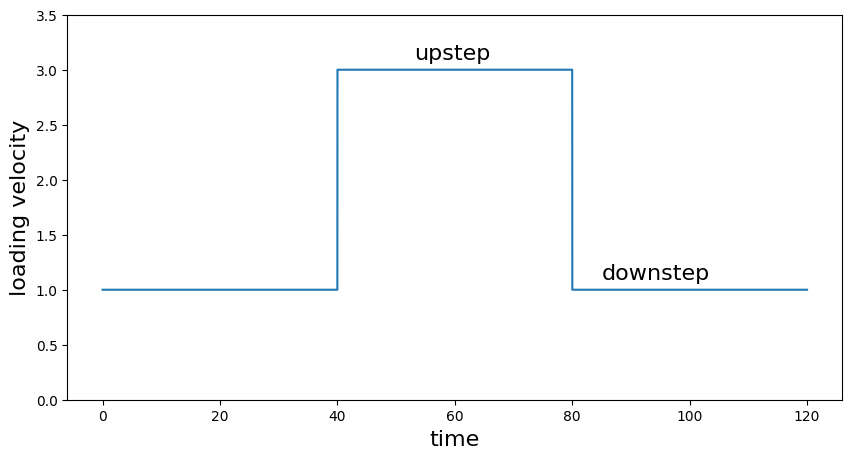

In [21]:
Nt        = 100000
t         = np.linspace(0, 120., Nt)

plt.figure(figsize=(10, 5))

plt.xlabel("time", fontsize = 16)
plt.ylabel("loading velocity", fontsize = 16)
plt.plot(t,vload(t,1))
plt.ylim([0,3.5])

plt.text(53,3.1, 'upstep', fontsize = 16)
plt.text(85,1.1, 'downstep', fontsize = 16)

Cool. Now here's is what the loading experiment looks like in terms of the displacement.

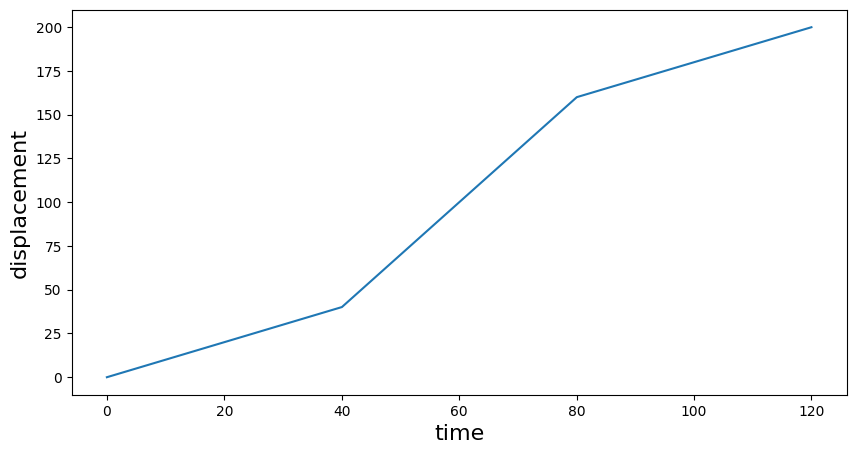

In [22]:
par       = rs2_parameters()

par.kappa = 3 # set the stiffness
x0     = [0, 0., 0.] # set the initial conditions
x   = ode_solver(rsf_ode,x0,t,par) # solve the ODEs

plt.figure(figsize=(10, 5))

plt.xlabel("time", fontsize = 16)
plt.ylabel("displacement", fontsize = 16)
plt.plot(t,x[:,2]);plt.show()

Now what does the slider do? Let's plot the difference in actual velocity minus the prescribed velocity.

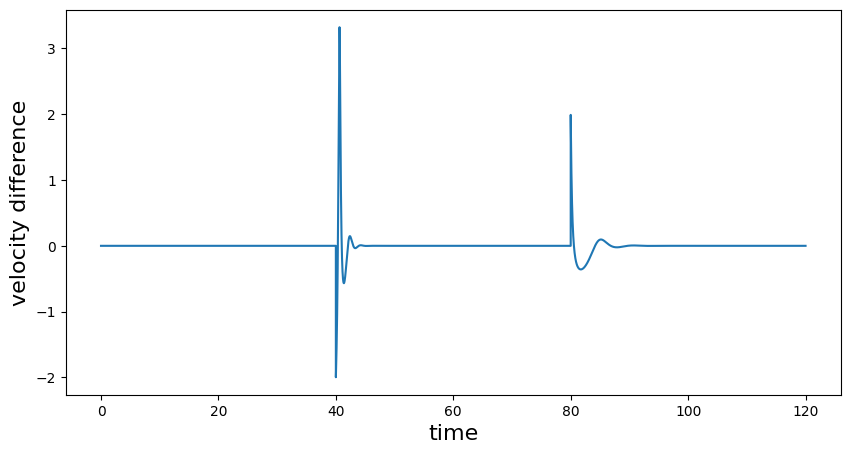

In [23]:
plt.figure(figsize=(10, 5))

plt.xlabel("time", fontsize = 16)
plt.ylabel("velocity difference", fontsize = 16)
plt.plot(t,np.exp(x[:,0])-vload(t, par.mode));plt.show()

And here is the corresponding shear stress.

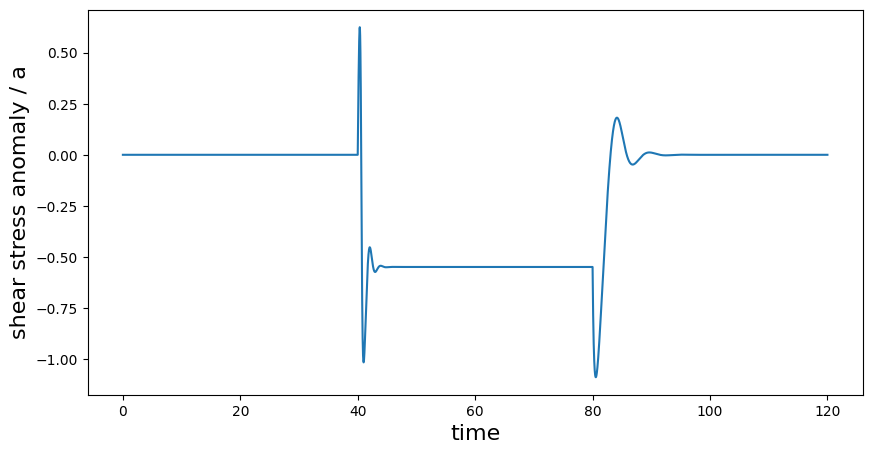

In [24]:
plt.figure(figsize=(10, 5))

plt.xlabel("time", fontsize = 16)
plt.ylabel("shear stress anomaly / a", fontsize = 16)
plt.plot(t,x[:,1]);plt.show()

What behavior does the friction show in terms of velocity dependence?

Now, let's see what this does for different values of $\kappa_c$. Change $\kappa$ from 50, 5, 1 $\kappa_c$, for example. 

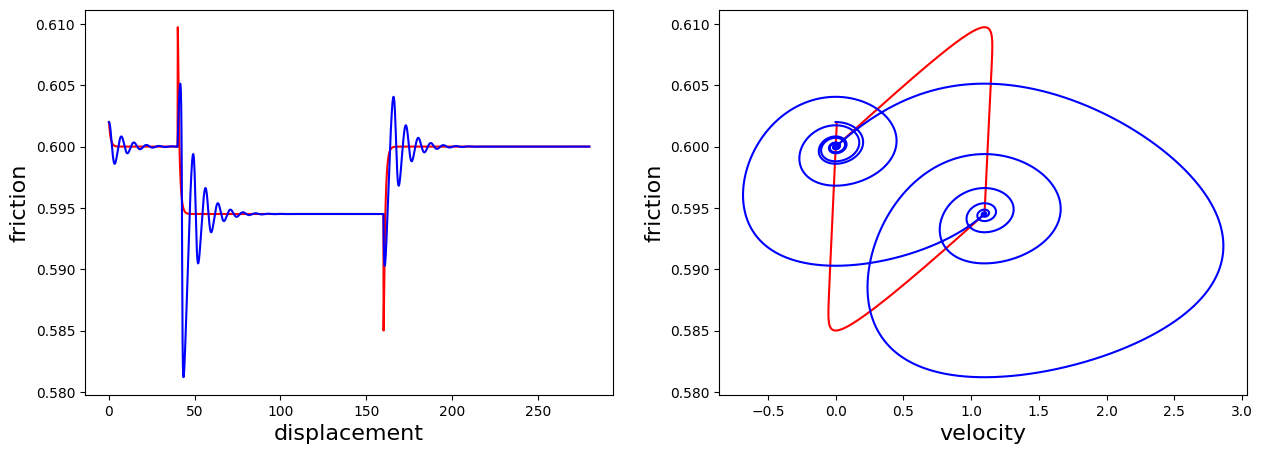

In [35]:
par       = rs2_parameters()
Nt        = 500000
t         = np.linspace(0, 200., Nt)
par.kappa = 50
x0     = [0, 0.2, 0.]
x1   = ode_solver(rsf_ode,x0,t,par)
par.kappa = 1.5
x2   = ode_solver(rsf_ode,x0,t,par)

fric1=par.mu_0 + x1[:,1]*par.a
fric2=par.mu_0 + x2[:,1]*par.a

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)

plt.subplot(1,2,1)
plt.plot(x1[:,2],fric1, 'red',x2[:,2],fric2,'blue')
plt.xlabel("displacement", fontsize = 16)
plt.ylabel("friction", fontsize = 16)

plt.subplot(1,2,2)
plt.plot(x1[:,0],fric1,'red',x2[:,0],fric2,'blue')
plt.xlabel("velocity", fontsize = 16)
plt.ylabel("friction", fontsize = 16)
plt.show()

What is happening? Can you analyze the phase space behavior? What might the system do, i.e. what are possible curves?